# PS reconstruction slice emittance example

In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

from phase_space_reconstruction.virtual.beamlines import quadlet_tdc_bend
from phase_space_reconstruction.virtual.scans import run_3d_scan, run_t_scan
from phase_space_reconstruction.diagnostics import ImageDiagnostic
from phase_space_reconstruction.visualization import plot_3d_scan_data
from phase_space_reconstruction.train import train_3d_scan, train_3d_scan_parallel_gpus

from bmadx.beam_generator import create_beam
from bmadx.plot import plot_projections
from bmadx.constants import PI

## Create synthetic ground truth beam

In [2]:
# create synthetic ground truth beam from base and transform yaml files
from distgen import Generator
from bmadx.coordinates import openpmd_to_bmadx
from bmadx.bmad_torch.track_torch import Beam
from bmadx.constants import M_ELECTRON

p0c = 43.36e6 # reference momentum in eV/c
base_yaml = "base.yaml"
gen = Generator(base_yaml)
emit=100
xbeta_params= {
    'type':'set_twiss x',
    'beta': {'value':25, 'units':'m'},
    'alpha':{'value':-1.5, 'units':''},
    'emittance':  {'value':emit,'units':'nm'},
}
gen["transforms"] = {"rot2": xbeta_params, "order": ["rot2"]}
particle_group1 = gen.run()

xbeta_params= {
    'type':'set_twiss x',
    'beta': {'value':5, 'units':'m'},
    'alpha':{'value':0, 'units':''},
    'emittance':  {'value':emit,'units':'nm'},
}
transz = {'type':'translate z', 'delta': '1 mm'}
gen["transforms"] = {"rot2": xbeta_params,"z": transz, "order": ["rot2","z"]}
particle_group2 = gen.run()

xbeta_params= {
    'type':'set_twiss x',
    'beta': {'value':60, 'units':'m'},
    'alpha':{'value':0, 'units':''},
    'emittance':  {'value':emit,'units':'nm'},
}
transz = {'type':'translate z', 'delta': '-1 mm'}

gen["transforms"] = {"rot2": xbeta_params,"z": transz, "order": ["rot2","z"]}
particle_group3 = gen.run()

particle_group = particle_group1 + particle_group2 + particle_group3

particle_group.drift_to_z(z=0)

coords = np.array(openpmd_to_bmadx(particle_group, p0c)).T
tkwargs = {"dtype": torch.float32}
coords = torch.tensor(coords, **tkwargs)

# create Bmad-X torch Beam:
gt_beam = Beam(
    coords,
    s=torch.tensor(0.0, **tkwargs),
    p0c=torch.tensor(p0c, **tkwargs),
    mc2=torch.tensor(M_ELECTRON, **tkwargs)
)

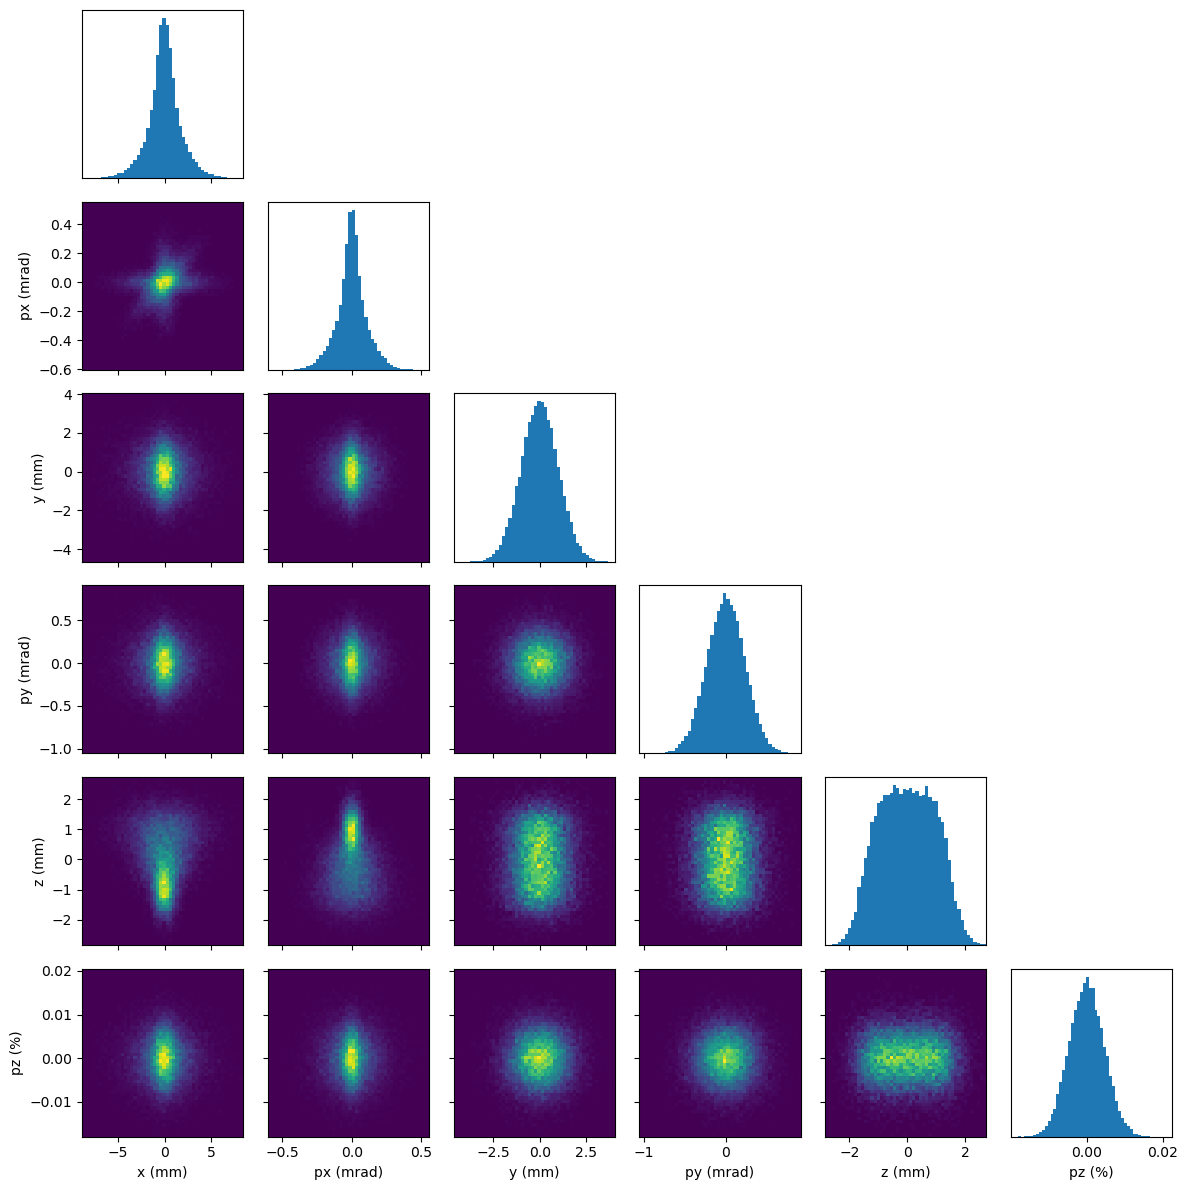

In [3]:
#plot gt beam
lims = np.array([[-15e-3, 15e-3],
                 [-15e-3, 15e-3],
                 [-15e-3, 15e-3],
                 [-15e-3, 15e-3],
                 [-15e-3, 15e-3],
                 [-10e-2, 10e-2]]) 
fig, ax = plot_projections(
    gt_beam.numpy_particles(),
    same_lims=False,
    background = 1
)
plt.show()

## Define diagnostics lattice parameters

In [4]:
# triplet params obtained from triplet-opt.ipynb
k1 = 7.570125
k2 = -15.704693
k3 = 1.0

In [5]:
# diagnostic beamline:
lattice = quadlet_tdc_bend(p0c=p0c, dipole_on=False)
#lattice.elements[0].K1.data = torch.tensor(k1)
#lattice.elements[2].K1.data = torch.tensor(k2)
#lattice.elements[4].K1.data = torch.tensor(k3)

# Scan over quad strength, tdc on/off and dipole on/off
scan_ids = [6, 8, 10] 
n_ks = 7
ks = torch.linspace(-10, 10, n_ks) # quad ks
vs = torch.tensor([0, 5e6]) # TDC off/on
gs = torch.tensor([2.22e-16, 20.0*PI/180.0/0.365]) # dipole off/on
train_params = torch.stack(torch.meshgrid(ks, vs, gs, indexing='ij'))
print(train_params.shape)
print(train_params.unsqueeze(-1).shape)

# create diagnostic screen: 
bins = torch.linspace(-20, 20, 200) * 1e-3
bandwidth = (bins[1]-bins[0]) / 2
screen = ImageDiagnostic(bins, bins, bandwidth)

torch.Size([3, 7, 2, 2])
torch.Size([3, 7, 2, 2, 1])


## Complete 3D scan training data

In [6]:
# generate and save train and test datasets
train_dset_3d_scan = run_3d_scan(
    gt_beam, 
    lattice,
    screen, 
    ks, vs, gs,
    ids = scan_ids,
    save_as = '3d_scan_train.dset'
)

print(train_dset_3d_scan.params.shape)
print(train_dset_3d_scan.images.shape)

dataset saved as '3d_scan_train.dset'
torch.Size([28, 3, 1])
torch.Size([28, 1, 200, 200])


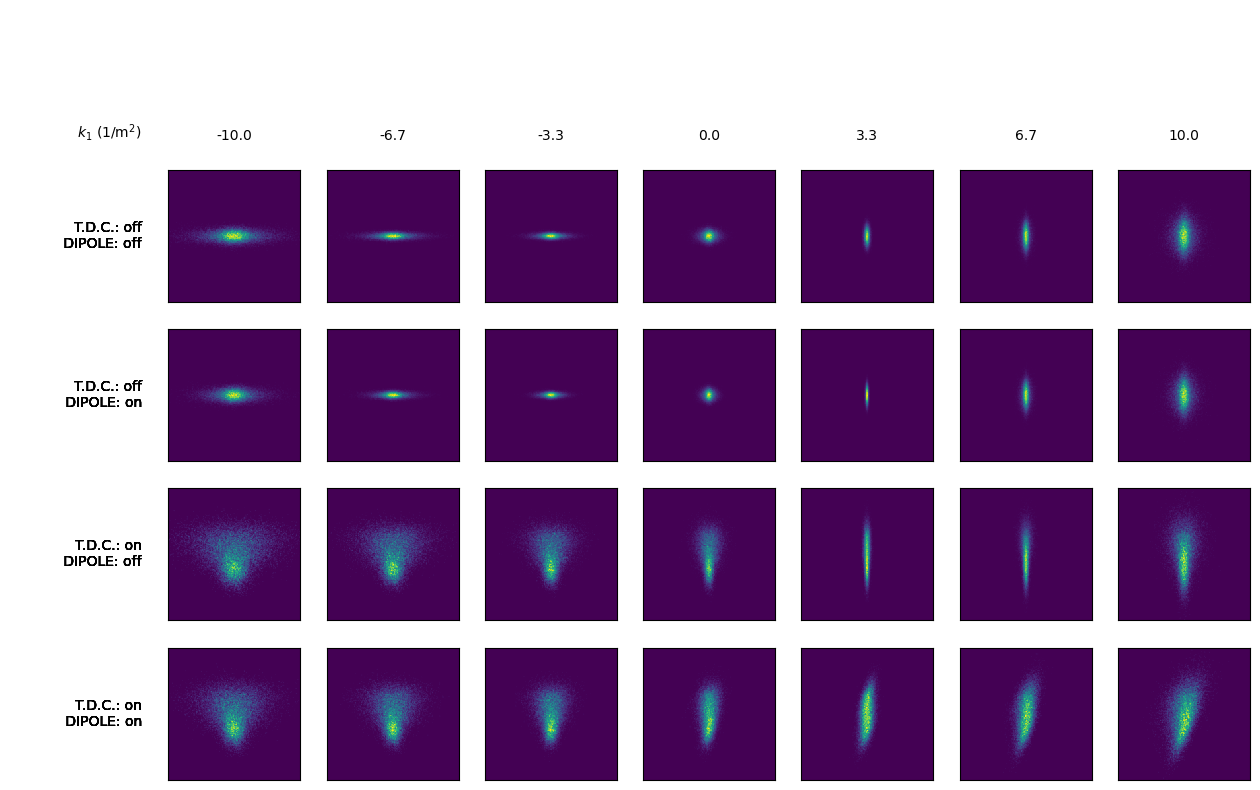

In [7]:
fig, ax = plot_3d_scan_data(train_dset_3d_scan)
plt.show()

### 10,000 particles, multi-GPU

In [8]:
%%time

# training with 4 gpus
pred_beam_3d_scan_10_000 = train_3d_scan(
    train_dset_3d_scan, 
    lattice, 
    p0c, 
    screen,
    ids = scan_ids,
    n_epochs = 1_000, 
    n_particles = 10_000, 
    device = 'cuda:0'
    )

Using device: cuda:0


C:\Users\Ryan Roussel\mambaforge\envs\phase_space_reconstruction\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


0 tensor(3656789.2500, device='cuda:0', grad_fn=<MulBackward0>)
100 tensor(846735.5625, device='cuda:0', grad_fn=<MulBackward0>)
200 tensor(811963.8125, device='cuda:0', grad_fn=<MulBackward0>)
300 tensor(774059.8750, device='cuda:0', grad_fn=<MulBackward0>)
400 tensor(766107.7500, device='cuda:0', grad_fn=<MulBackward0>)
500 tensor(806264.7500, device='cuda:0', grad_fn=<MulBackward0>)
600 tensor(781948.9375, device='cuda:0', grad_fn=<MulBackward0>)
700 tensor(890174.5625, device='cuda:0', grad_fn=<MulBackward0>)
800 tensor(712555.8125, device='cuda:0', grad_fn=<MulBackward0>)
900 tensor(762740., device='cuda:0', grad_fn=<MulBackward0>)
CPU times: total: 7min 25s
Wall time: 7min 31s


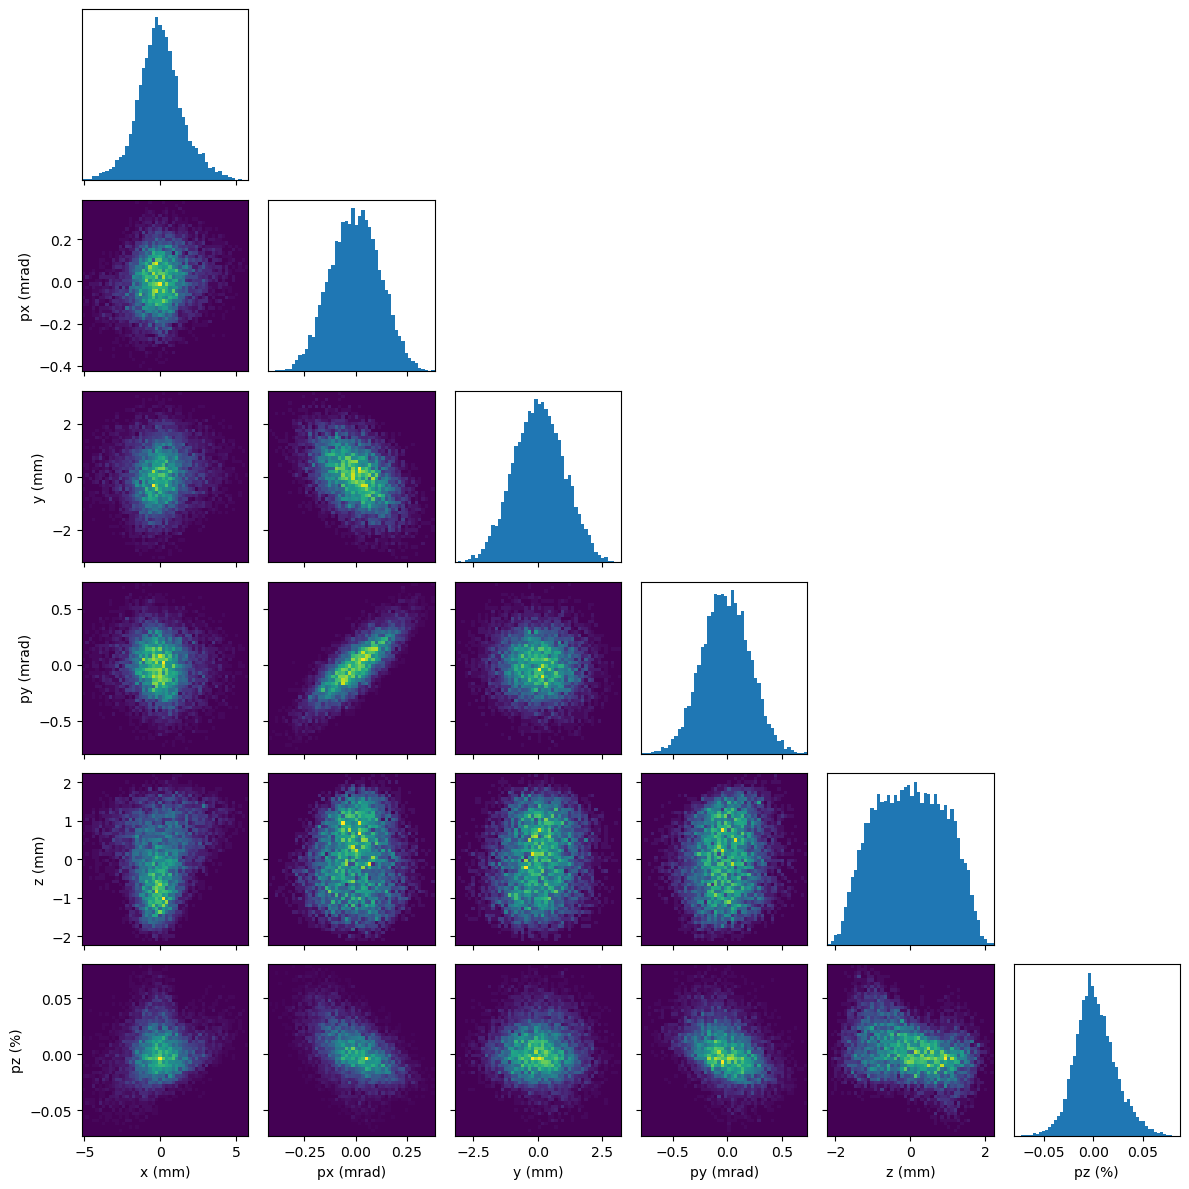

In [9]:
# reconstructed beam projections:
fig, ax = plot_projections(
    pred_beam_3d_scan_10_000.numpy_particles(),
    same_lims=False,
    background = 1
)

In [10]:
torch.cuda.empty_cache()

In [11]:
torch.save(
    pred_beam_3d_scan_10_000,
    os.path.join(save_dir, '3D_scan_10_000.pt'))

type: name 'save_dir' is not defined